# Sea Surface Height (SSH)

* This notebook plots global SSH diagnostics and Florida Strait Transport
* Author: Jacob Steinberg

In [1]:
# For testing and development purposes, enter a start year, end year, and
# an dora id number to analyze. The value of dora_id can also be a direct
# path to a /pp directory.

config = {
    "startyr": "1990",
    "endyr": "2010",
    "dora_id": "odiv-384,odiv-411,odiv-414",
}

In [2]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [3]:
print(str(config))

{'startyr': '1990', 'endyr': '2010', 'dora_id': 'odiv-384,odiv-411,odiv-414'}


### Import Python Modules

In [4]:
import os
import datetime
from datetime import datetime, timedelta
import doralite
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import doralite
import glob
import subprocess
import momlevel
import momgrid
import itertools
from math import radians, degrees, sin, cos, asin, acos, sqrt
from datetime import timedelta

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

import warnings
warnings.filterwarnings('ignore')

numpy version  :  1.23.5
pandas version :  2.1.1
xarray version :  2023.10.1


In [5]:
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

### Define Local Parameters

In [6]:
# List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

for exp in experiments:
    print(exp["pathPP"])

for n,id in enumerate(config["dora_id"].split(",")):
    if exp["id"] is None:
        exp["id"] = id

print(start,end)

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240805/om5_b06_nonBouss/gfdl.ncrc5-intel23-prod/pp/
1990 2010


In [7]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [8]:
datafiles = {}
staticfiles = {}
filelist_total = []
_staticfile_total = []
count = 0
for experiment in experiments:
    _pathPP = experiment["pathPP"]
    
    # -- create filelist of static grid file + 2d fields in time (like zos)
    component = "ocean_monthly"
    static = f"{component}/{component}.static.nc"
    varname = ["zos","ssh_ga"]
    chunk = "5yr"
    
    for i in range(len(varname)):
        if i < 1:
            filelist = sorted(glob.glob(f"{_pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname[i]}.nc"))
        else:
            filelist = np.concatenate((filelist,sorted(glob.glob(f"{_pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname[i]}.nc"))))
    
    # -- will append to filelist if we want additional 3d fields (like vmo)
    # (consider toggling for fasting run times?)
    component = "ocean_monthly_z"
    varname = ["vmo"]
    for i in range(len(varname)):
        filelist = np.concatenate((filelist,sorted(glob.glob(f"{_pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname[i]}.nc"))))
    
    filelist = [x for x in filelist if is_in_range(x,start,end)]
    _staticfile = f"{_pathPP}{static}"
    
    # -- for loading by model run
    staticfiles[experiment['requested_id']] = _staticfile
    datafiles[experiment['requested_id']] = filelist
    # -- construct one long list for dora to spit out / needs to be dmgot
    filelist_total.append(filelist)
    _staticfile_total.append(_staticfile)

In [9]:
# construct one long filelist for dmget
allfiles = sorted(list(itertools.chain(*filelist_total)) + _staticfile_total)
_ = [print(x) for x in allfiles]
# cell tag 'stop_here' added

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ocean_monthly.static.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.ssh_ga.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.zos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.ssh_ga.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.zos.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.ssh_ga.nc
/archive/Brandon.Reichl/fre_om5/F

In [10]:
# issue dmget (will hang until files are on disk)
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


In [11]:
ds_out = {}
for experiment in experiments:
    name = experiment['requested_id']
    # - todo - rewrite to call and build dataset from momgrid
    # ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
    # model_type = ds.model
    
    ds = xr.open_mfdataset(datafiles[name]) #  use_cftime=True
    sg = xr.open_dataset(staticfiles[name])
    ds = ds.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))
    
    ds = ds.assign_coords({
        'geolon': xr.DataArray(sg['geolon'].values, dims=('yh','xh')), # .isel(xh=slice(ixs,ixe),yh=slice(iys,iye))
        'geolat': xr.DataArray(sg['geolat'].values, dims=('yh','xh')),
        'geolon_u': xr.DataArray(sg['geolon_u'].values, dims=('yh','xq')),
        'geolat_u': xr.DataArray(sg['geolat_u'].values, dims=('yh','xq')),
        'geolon_v': xr.DataArray(sg['geolon_v'].values, dims=('yq','xh')),
        'geolat_v': xr.DataArray(sg['geolat_v'], dims=('yq','xh')),
        'geolon_c': xr.DataArray(sg['geolon_c'], dims=('yq','xq')),
        'geolat_c': xr.DataArray(sg['geolat_c'], dims=('yq','xq')),
        'deptho': xr.DataArray(sg['deptho'], dims=('yh', 'xh',)),
        })
    ds = ds.assign_attrs(exp=name)
    ds_out[name] = ds

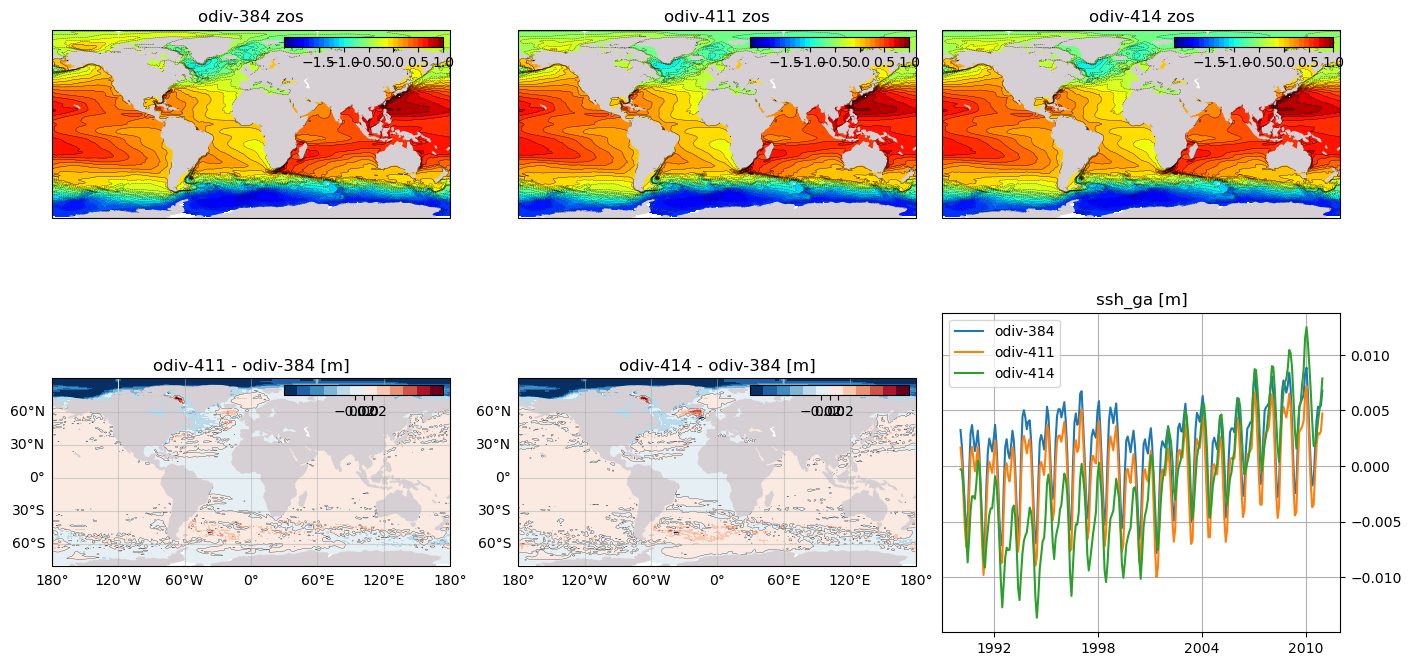

In [12]:
# -- global zos --
odivs = config['dora_id'].split(",")
lon_w = -180; lon_e = 180; lat_s = -80; lat_n = 90; levs=np.arange(-2.2,1.1,0.1)

# -- change figure size depending on how many runs are being compared (can improved this)
if len(ds_out) > 1:
    s_w = 14; s_h = 7;
else:
    s_w = 8; s_h = 6;
    
fig = plt.figure(figsize=(s_w,s_h), layout='constrained')
gs = fig.add_gridspec(2, len(ds_out))
axts = fig.add_subplot(gs[1, len(ds_out)-1])
# -- plot global zos
for i in range(len(ds_out)):
    ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    cc0 = ax.contourf(ds_out[odivs[i]]['geolon'],ds_out[odivs[i]]['geolat'],ds_out[odivs[i]]['zos'].mean(dim='time'),transform=ccrs.PlateCarree(),levels=levs,cmap=plt.get_cmap('jet'))
    ax.contour(ds_out[odivs[i]]['geolon'],ds_out[odivs[i]]['geolat'],ds_out[odivs[i]]['zos'].mean(dim='time'),transform=ccrs.PlateCarree(),levels=levs,colors='k',linewidths=0.25)
    ax.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
    ax.set_xlim([lon_w,lon_e]); ax.set_ylim([lat_s,lat_n]); 
    ax.set_title(odivs[i] + ' zos');
    axins1 = inset_axes(ax, width="40%",height="5%",loc="upper right")
    ax.xaxis.set_ticks_position("bottom")
    fig.colorbar(cc0, cax=axins1, orientation="horizontal", ticks=[-1.5,-1,-0.5,0,0.5,1])

st = 4 # decimate to make pcolor runtime shorter
# -- if we are comparing two or more runs -- make difference plot
if len(ds_out) > 1:
    # -- loop over and difference from the first
    for i in range(len(ds_out) - 1):
        # -- re-grid for difference map
        os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/jpk/grid_weights/"
        xrds1 = ds_out[odivs[0]].drop('vmo')
        xrds2 = ds_out[odivs[i+1]].drop(['vmo','geolon_u','geolat_u','geolon_v','geolat_v','geolon_c','geolat_c','xq','yq'])
        gds1 = momgrid.Gridset(xrds1); # input = input the result of open_mfdataset (not a data variable) [file documentation issue]
        gds1_remapped = gds1.regrid(resolution=0.25);
        gds2 = momgrid.Gridset(xrds2); # input = input the result of open_mfdataset (not a data variable) [file documentation issue]
        gds2_remapped = gds2.regrid(resolution=0.25);
        zos_diff = gds2_remapped['zos'].mean(dim='time') - gds1_remapped['zos'].mean(dim='time')
    
        # -- plot 
        axd = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
        cc1 = axd.pcolor(gds1_remapped.lon[::st],gds1_remapped.lat[::st],zos_diff[::st,::st],transform=ccrs.PlateCarree(),vmin=-4*np.nanstd(zos_diff),vmax=4*np.nanstd(zos_diff),cmap=plt.get_cmap('RdBu_r',12))
        axd.contour(gds1_remapped.lon[::st],gds1_remapped.lat[::st],zos_diff[::st,::st],transform=ccrs.PlateCarree(),levels=[0],colors='k',linewidths=0.2)
        axd.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
        axd.set_xlim([lon_w,lon_e]); axd.set_ylim([lat_s,lat_n]); 
        axd.set_title(odivs[i+1] + ' - ' + odivs[0] + ' [m]');
        gl = axd.gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.right_labels = False; # gl.bottom_labels = False; gl.left_labels = False;
        # fig.colorbar(cc1, ax=axd, extend='neither', label='m', shrink=0.6, pad=0.01);
        axins1 = inset_axes(axd, width="40%",height="5%",loc="upper right")
        axd.xaxis.set_ticks_position("bottom")
        fig.colorbar(cc1, cax=axins1, orientation="horizontal", ticks=[-0.02,0,0.02])
    
    # -- loop through and plot ssh_ga if it is saved
    for j in range(len(ds_out)):
        if "ssh_ga" in ds_out[odivs[j]]:
            axts.plot(ds_out[odivs[j]]['time'],ds_out[odivs[j]]['ssh_ga'],label=odivs[j])  
            
# -- if only one experiment, only plot ssh_ga (no difference)
else:
    if "ssh_ga" in ds_out[odivs[0]]:
        axts.plot(ds_out[odivs[0]]['time'],ds_out[odivs[0]]['ssh_ga'],label=odivs[0])

axts.set_title('ssh_ga [m]'); axts.legend(); axts.yaxis.tick_right(); axts.grid()
# -- construct filename for saving
for i in range(len(ds_out)):
    if i < 1:
        fname = odivs[i]
    else:
        fname = fname  + odivs[i]
# plt.savefig('/home/jms/meetings/2024_08_19/global_zos_' + fname + '.jpg',dpi=450)

### zoom in and compare GS to obs.

In [13]:
# -- zoom in domain bounds -- 
lon_w = -99; lon_e = -45; lat_s = 18; lat_n = 52;  # GS

In [14]:
# -- load satellite alimtetry -- 
ds_al = xr.open_dataset('/nbhome/jms/cmems_l4_ssh/c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_2018_2022.nc') # c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_P1D_1710782026645.nc')
ssh_alt_0 = ds_al.adt.load()
# -- OPTION to resample in time
ssh_alt = ssh_alt_0 #_0.resample(time="M").mean() 
# -- OPTION to subset in space
ssh_alt = ssh_alt.sel(longitude=slice(lon_w,lon_e), latitude=slice(lat_s, lat_n))
# -- OPTION to choose reference level
# ref_to_model = out_dict[exps[0]]['zos_m'].sel(yh=slice(20,47),xh=slice(-82,-50)).mean(dim=('yh','xh')) 
ref_alt = ssh_alt.mean(dim=('latitude','longitude')) # + ssh_alt.mean(dim=('time','yh','xh')) 

ssha_alt = ssh_alt - ref_alt # subtract spatial mean over this domain
ssha_alt_mean = ssha_alt.mean(dim='time')
ssha_alt_var = ssha_alt.var(dim='time')

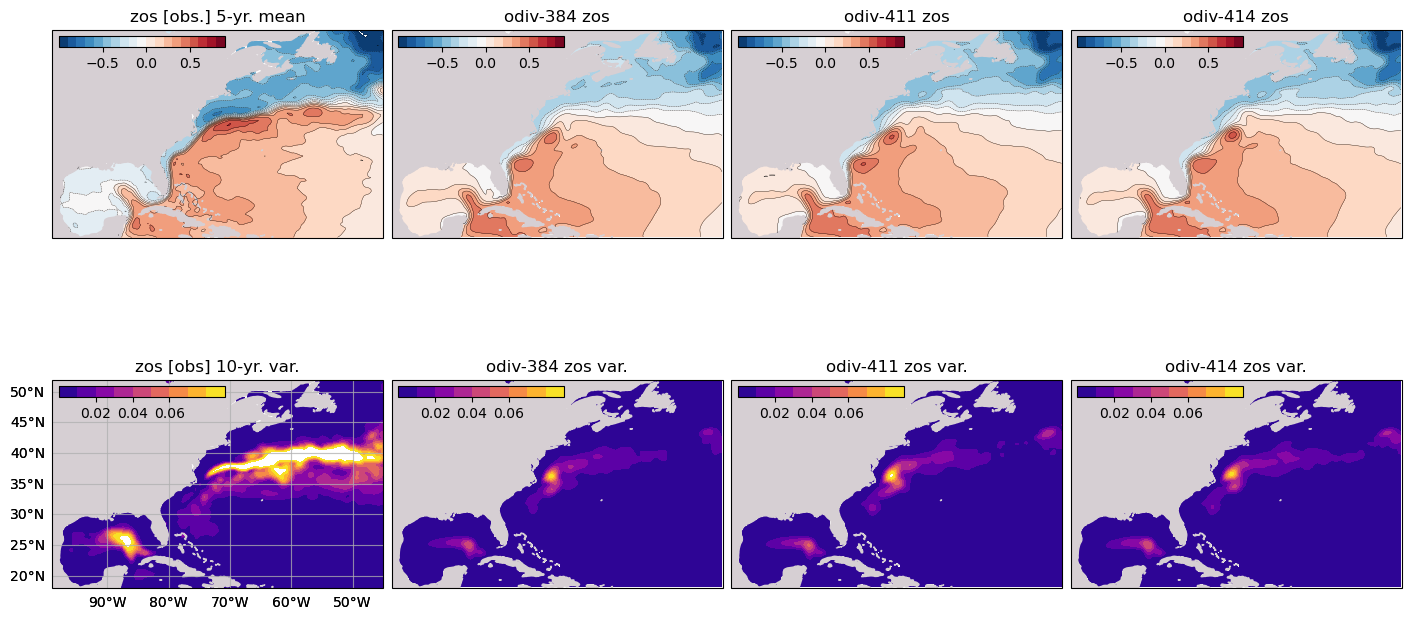

In [15]:
fig = plt.figure(figsize=(s_w,s_h), layout='constrained')
gs = fig.add_gridspec(2, len(ds_out)+1); levs = np.arange(-1,1,0.1)
# -- plot obs
axo = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
c1 = axo.contourf(ssh_alt.longitude, ssh_alt.latitude, ssha_alt_mean, transform=ccrs.PlateCarree(),levels=levs,cmap=plt.get_cmap('RdBu_r'));
axo.contour(ssh_alt.longitude, ssh_alt.latitude, ssha_alt_mean, transform=ccrs.PlateCarree(),levels=levs,colors='k',linewidths=0.25)
axo.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
axo.set_xlim([lon_w,lon_e]); axo.set_ylim([lat_s,lat_n]); axo.set_title('zos [obs.] 5-yr. mean');
axins1 = inset_axes(axo, width="50%",height="5%",loc="upper left")
axo.xaxis.set_ticks_position("bottom")
fig.colorbar(c1, cax=axins1, orientation="horizontal", ticks=[-0.5, 0, 0.5])

axo = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
gl = axo.gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.right_labels = False;
c2 = axo.contourf(ssh_alt.longitude, ssh_alt.latitude, ssha_alt_var, transform=ccrs.PlateCarree(),levels=np.arange(0,0.1,0.01),cmap=plt.get_cmap('plasma'));
axo.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
axo.set_xlim([lon_w,lon_e]); axo.set_ylim([lat_s,lat_n]); axo.set_title('zos [obs] 10-yr. var.');
gl = axo.gridlines(draw_labels=True,alpha=0.5); gl.top_labels = False; gl.right_labels = False;

axins1 = inset_axes(axo, width="50%",height="5%",loc="upper left")
axo.xaxis.set_ticks_position("bottom")
fig.colorbar(c2, cax=axins1, orientation="horizontal", ticks=[0.02,0.04,0.06])

# -- plot model
for i in range(len(ds_out)):
    
    lonsub = ds_out[odivs[i]]['geolon'].sel(xh=slice(lon_w,lon_e), yh=slice(lat_s, lat_n))
    latsub = ds_out[odivs[i]]['geolat'].sel(xh=slice(lon_w,lon_e), yh=slice(lat_s, lat_n))
    zossub = ds_out[odivs[i]]['zos'].sel(xh=slice(lon_w,lon_e), yh=slice(lat_s, lat_n))
    zossub = zossub - zossub.mean(dim=('xh','yh'))
    
    ax = fig.add_subplot(gs[0, i+1], projection=ccrs.PlateCarree())
    cc0 = ax.contourf(lonsub,latsub,zossub.mean(dim='time'),transform=ccrs.PlateCarree(),levels=levs,cmap=plt.get_cmap('RdBu_r'))
    ax.contour(lonsub,latsub,zossub.mean(dim='time'),transform=ccrs.PlateCarree(),levels=levs,colors='k',linewidths=0.25)
    ax.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
    ax.set_xlim([lon_w,lon_e]); ax.set_ylim([lat_s,lat_n]); 
    ax.set_title(odivs[i] + ' zos');
    axins1 = inset_axes(ax, width="50%",height="5%",loc="upper left")
    ax.xaxis.set_ticks_position("bottom")
    fig.colorbar(cc0, cax=axins1, orientation="horizontal", ticks=[-0.5, 0, 0.5])
    
    ax2 = fig.add_subplot(gs[1, i+1], projection=ccrs.PlateCarree())
    cc1 = ax2.contourf(lonsub,latsub,zossub.var(dim='time'),transform=ccrs.PlateCarree(),levels=np.arange(0,0.1,0.01),cmap=plt.get_cmap('plasma'))
    ax2.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
    ax2.set_xlim([lon_w,lon_e]); ax2.set_ylim([lat_s,lat_n]); 
    ax2.set_title(odivs[i] + ' zos var.');
    axins1 = inset_axes(ax2, width="50%",height="5%",loc="upper left")
    ax2.xaxis.set_ticks_position("bottom")
    fig.colorbar(cc1, cax=axins1, orientation="horizontal", ticks=[0.02,0.04,0.06])

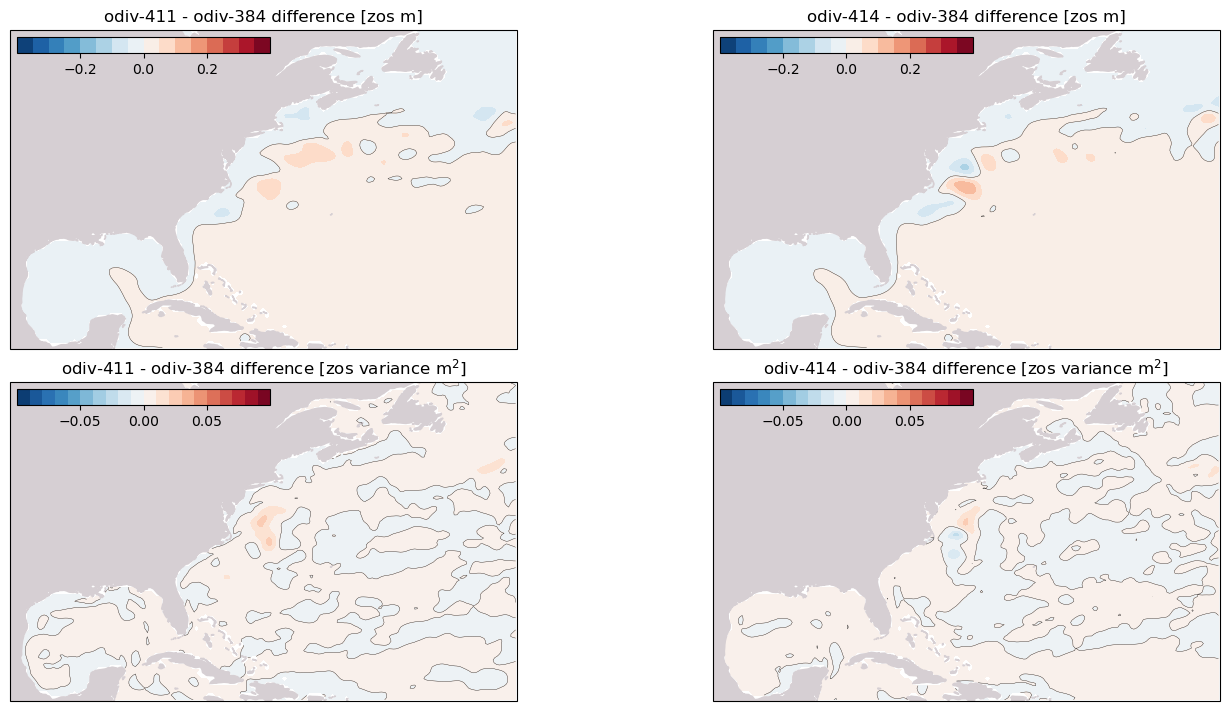

In [16]:
# plot zoomed in difference map if multiple experiments are included
if len(ds_out) > 1:
    fig2 = plt.figure(figsize=(s_w,s_h), layout='constrained')
    gs = fig2.add_gridspec(2, len(ds_out)-1)
    for i in range(len(ds_out)-1):
        
        # -- re-grid for difference map
        os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/jpk/grid_weights/"
        xrds1 = ds_out[odivs[0]].drop(['vmo','geolon_u','geolat_u','geolon_v','geolat_v','geolon_c','geolat_c','xq','yq'])
        xrds2 = ds_out[odivs[i+1]].drop(['vmo','geolon_u','geolat_u','geolon_v','geolat_v','geolon_c','geolat_c','xq','yq'])
        gds1 = momgrid.Gridset(xrds1); # input = input the result of open_mfdataset (not a data variable) [file documentation issue]
        gds1_remapped = gds1.regrid(resolution=0.25);
        gds2 = momgrid.Gridset(xrds2); # input = input the result of open_mfdataset (not a data variable) [file documentation issue]
        gds2_remapped = gds2.regrid(resolution=0.25);

        lonsub = gds1_remapped['lon'].sel(lon=slice(lon_w,lon_e))
        latsub = gds1_remapped['lat'].sel(lat=slice(lat_s, lat_n))
        zossub1 = gds1_remapped['zos'].sel(lon=slice(lon_w,lon_e), lat=slice(lat_s, lat_n))
        zossub1 = zossub1 - zossub1.mean(dim=('lon','lat'))
        zossub2 = gds2_remapped['zos'].sel(lon=slice(lon_w,lon_e), lat=slice(lat_s, lat_n))
        zossub2 = zossub2 - zossub2.mean(dim=('lon','lat'))
        zossub_diff = zossub2.mean(dim='time') - zossub1.mean(dim='time')
        zossub_var_diff = zossub2.var(dim='time') - zossub1.var(dim='time')
        
        ax = fig2.add_subplot(gs[0,i], projection=ccrs.PlateCarree())
        cc0 = ax.contourf(lonsub,latsub,zossub_diff,transform=ccrs.PlateCarree(),levels=np.arange(-0.4,0.45,0.05),cmap=plt.get_cmap('RdBu_r'))
        ax.contour(lonsub,latsub,zossub_diff,transform=ccrs.PlateCarree(),levels=[0],colors='k',linewidths=0.25)
        ax.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
        ax.set_xlim([lon_w,lon_e]); ax.set_ylim([lat_s,lat_n]); 
        ax.set_title(odivs[i+1] + ' - ' + odivs[0] + ' difference [zos m]');
        axins1 = inset_axes(ax, width="50%",height="5%",loc="upper left")
        ax.xaxis.set_ticks_position("bottom")
        fig2.colorbar(cc0, cax=axins1, orientation="horizontal", ticks=[-0.2,0,0.2])
        ax = fig2.add_subplot(gs[1,i], projection=ccrs.PlateCarree())
        cc0 = ax.contourf(lonsub,latsub,zossub_var_diff,transform=ccrs.PlateCarree(),levels=np.arange(-0.1,0.11,0.01),cmap=plt.get_cmap('RdBu_r'))
        ax.contour(lonsub,latsub,zossub_var_diff,transform=ccrs.PlateCarree(),levels=[0],colors='k',linewidths=0.25)
        ax.add_feature(cartopy.feature.LAND, color='#D6CFD3', zorder=1); 
        ax.set_xlim([lon_w,lon_e]); ax.set_ylim([lat_s,lat_n]); 
        ax.set_title(odivs[i+1] + ' - ' + odivs[0] + ' difference [zos variance m$^2$]');
        axins1 = inset_axes(ax, width="50%",height="5%",loc="upper left")
        ax.xaxis.set_ticks_position("bottom")
        fig2.colorbar(cc0, cax=axins1, orientation="horizontal", ticks=[-0.05,0,0.05])

### Florida Strait Transport

In [17]:
# load obs
obs_fs_t_f = open('/nbhome/jms/FS_transport_CPiecuch_2024.txt', "r") # .read()
obs_fs_0 = []
for x in obs_fs_t_f:
    obs_fs_0.append(x.split(","))
obs_fs = np.nan*np.ones((len(obs_fs_0)-1,2))
obs_fs_dt = []
for xx in range(len(obs_fs)):
    obs_fs[xx,:] = np.array([np.int(obs_fs_0[xx+1][0]),np.float64(obs_fs_0[xx+1][1][:-2])])
    obs_fs_dt.append((datetime.fromordinal(int(obs_fs[xx,0])) + timedelta(days=obs_fs[xx,0]%1) - timedelta(days = 366)))
# obs_fs
da_obs_fs = xr.DataArray(
    data=obs_fs[:,1],
    dims=["time"],
    coords=dict(
        time=(["time"], obs_fs_dt),
    ),
)

In [18]:
# -- Florida Strait transport
FS_out_dict = {}
pp = 0 # toggle for map plot
for i in range(len(ds_out)):
    lon_k = ds_out[odivs[i]]['geolon']
    lat_k = ds_out[odivs[i]]['geolat']
    lon_v_k = ds_out[odivs[i]]['geolon_v']
    lat_v_k = ds_out[odivs[i]]['geolat_v']
    ssh_k = ds_out[odivs[i]]['zos'] # [time, lat, lon]
    dep_k = ds_out[odivs[i]]['deptho']
    vmo_k = ds_out[odivs[i]]['vmo'] # [time, z, lat, lon

    # -- extract correct longitudinal section at ~26.5N
    FS_in = np.where((lon_k >= -80.75) & (lon_k <= -78.45) & (lat_k >= 26.5) & (lat_k <= 26.7))
    FS_v_in = np.where((lon_v_k >= -80.75) & (lon_v_k <= -78.45) & (lat_v_k >= 26.5) & (lat_v_k <= 26.7))
    FS_zos = ssh_k[:,FS_in[0][0]:FS_in[0][-1]+1,FS_in[1][0]:FS_in[1][-1]]
    FS_vmo_all = vmo_k[:, :, FS_v_in[0][0]:FS_v_in[0][-1]+1, FS_v_in[1][0]:FS_v_in[1][-1]+1]
    # -- do we want to partition across depths?
    FS_vmo = vmo_k[:,:,FS_v_in[0][0]:FS_v_in[0][-1]+1,FS_v_in[1][0]:FS_v_in[1][-1]+1].sum(dim='z_l').sum(dim='xh') # all depths
    
    # -- remove nans
    good = np.where(~np.isnan(FS_zos[0,0,:]))[0]
    FS_dh = FS_zos[:,0,good[-1]] - FS_zos[:,0,good[0]]
    FS_dx = great_circle(ssh_k.xh[FS_in[1][good][0]], ssh_k.yh[FS_in[0][0]], ssh_k.xh[FS_in[1][good][-1]], ssh_k.yh[FS_in[0][0]])*1000
    # -- compute surface transport from surface ssh gradient
    FS_ff = (2*(7.292e-5)*np.sin(np.deg2rad(26.0)))
    FS_transport = (9.81*(FS_dh/FS_dx)/FS_ff)*FS_dx*1/1000000
    FS_transport_sm = np.nan*FS_transport.copy();
    FS_transport_alt_sm = np.nan*FS_transport.copy();
    # -- smooth in time
    sw=12 # smoothing window (months)
    for j in range(np.int(sw/2), len(FS_transport) - np.int(sw/2)):
        FS_transport_sm[j] = np.nanmean(FS_transport[(j-np.int(sw/2)):(j+np.int(sw/2))])
    if np.int(str(ssh_k.time[0].values)[0:4]) > 1958:
        FS_out_dict[odivs[i]] = {'FS_surf_transport': FS_transport_sm, 'FS_transport': FS_vmo, 'FS_transport_all': FS_vmo_all, \
                                'FS_lon': lon_k[FS_in[0][0]:FS_in[0][-1]+1,FS_in[1][0]:FS_in[1][-1]+1][0], \
                                'FS_lon_v': lon_v_k[FS_v_in[0][0]:FS_v_in[0][-1]+1,FS_v_in[1][0]:FS_v_in[1][-1]+1][0], \
                                'FS_dep': dep_k[FS_in[0][0]:FS_in[0][-1]+1,FS_in[1][0]:FS_in[1][-1]+1][0], \
                                'time': ssh_k.time.indexes['time'].to_datetimeindex()} # .time.indexes['time'].to_datetimeindex() # ONLY DO THIS IF WE'RE RUNNING HISTORICAL SIMULATIONS 
    else:
        FS_out_dict[odivs[i]] = {'FS_surf_transport': FS_transport_sm, 'FS_transport': FS_vmo, 'FS_transport_all': FS_vmo_all, \
                                'FS_lon': lon_k[FS_in[0][0]:FS_in[0][-1]+1,FS_in[1][0]:FS_in[1][-1]+1][0], \
                                'FS_lon_v': lon_v_k[FS_v_in[0][0]:FS_v_in[0][-1]+1,FS_v_in[1][0]:FS_v_in[1][-1]+1][0], \
                                'FS_dep': dep_k[FS_in[0][0]:FS_in[0][-1]+1,FS_in[1][0]:FS_in[1][-1]+1][0], \
                                'time': ssh_k.time} # .time.indexes['time'].to_datetimeindex() # ONLY DO THIS IF WE'RE RUNNING HISTORICAL SIMULATIONS        
    # -- plotting check to see 'where' transect falls
    if pp > 0:
        f, ax1 = plt.subplots(1,1,figsize=(8,5),subplot_kw={'projection':ccrs.PlateCarree()})
        ax1.grid(True, which='minor', axis='both', linestyle='-', color='k', linewidth=0.1)
        ax1.set_xticks(ssh_k.xh, minor=True); ax1.set_yticks(ssh_k.yh[:], minor=True)
        ax1.contour(lon_k,lat_k,dep_k,levels=[100,500,1000],colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
        ax1.pcolor(lon_k[FS_in[0][0]:FS_in[0][-1]+2,FS_in[1][0]:FS_in[1][-1]], lat_k[FS_in[0][0]:FS_in[0][-1]+2,FS_in[1][0]:FS_in[1][-1]], ssh_k[:,FS_in[0][0]:FS_in[0][-1]+2,FS_in[1][0]:FS_in[1][-1]].mean(dim='time'),transform=ccrs.PlateCarree())
        ax1.add_feature(cartopy.feature.LAND, color='k', zorder=1); 
        ax1.set_xlim([-85,-75]); ax1.set_ylim([23,29]); 
        # plt.savefig('/home/jms/meetings/2024_08_05/FS_comp_key.jpg',dpi=450)

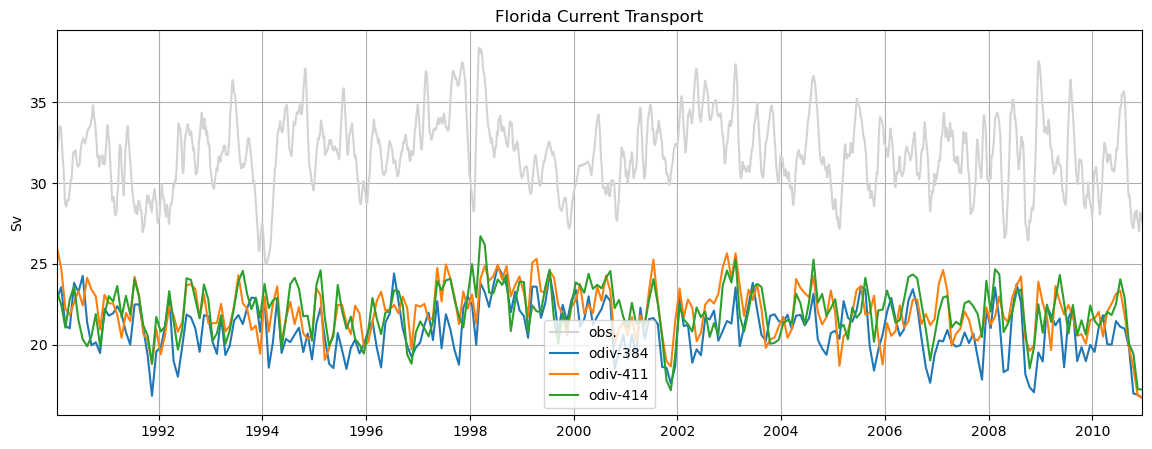

In [19]:
f, ax2 = plt.subplots(1,1,figsize=(14,5))
# if np.int(str(FS_out_dict[odivs[i]]['time'][0].values)[0:4]) > 1958:
if np.int(str(ssh_k.time[0].values)[0:4]) > 1958:
    ax2.plot(da_obs_fs.time,da_obs_fs.rolling(time=30,center=True).mean(),color='#d3d3d3',label='obs.')
else:
    fs_obs_rm = da_obs_fs.rolling(time=30,center=True).mean()
    ax2.plot(FS_out_dict[odivs[i]]['time'],((fs_obs_rm.mean(dim='time') - fs_obs_rm.std(dim='time')).data)*np.ones(len(FS_out_dict[odivs[i]]['time'])), color='k', linestyle='--', label='+/- obs. std.')
    ax2.plot(FS_out_dict[odivs[i]]['time'],((fs_obs_rm.mean(dim='time') + fs_obs_rm.std(dim='time')).data)*np.ones(len(FS_out_dict[odivs[i]]['time'])), color='k', linestyle='--')

# -- plot model runs
for i in range(len(ds_out)):
    ax2.plot(FS_out_dict[odivs[i]]['time'], FS_out_dict[odivs[i]]['FS_transport']/1e9,label=odivs[i])
ax2.grid(); ax2.legend(); ax2.set_ylabel('Sv'); 
ax2.set_title('Florida Current Transport'); 
ax2.set_xlim([FS_out_dict[odivs[i]]['time'][0], FS_out_dict[odivs[i]]['time'][-1]]); 
# plt.savefig('/home/jms/meetings/2024_08_05/FS_timeseries_odivs' + exps[0][-3:] + '_' + exps[1][-3:] + '.jpg',dpi=450)

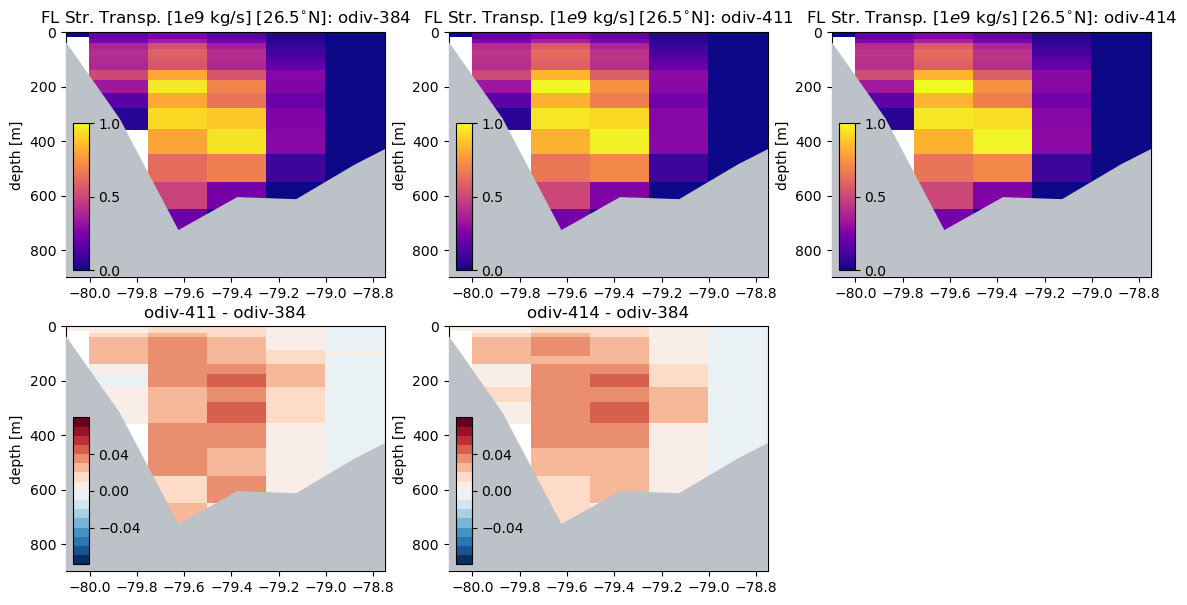

In [20]:
if len(ds_out) <= 1:
    f, ax = plt.subplots(1,1,figsize=(8,6))
    c1 = ax.pcolor(FS_out_dict[odivs[0]]['FS_lon_v'], \
                   FS_out_dict[odivs[0]]['FS_transport_all'].z_l, \
                   FS_out_dict[odivs[0]]['FS_transport_all'].isel(yq=0).mean(dim='time')/1e9, vmin=0, vmax=1, cmap=plt.get_cmap('plasma'))
    ax.fill_between(FS_out_dict[odivs[0]]['FS_lon'], FS_out_dict[odivs[0]]['FS_dep'], 8000, color='#bcc2c8',zorder=3)
    ax.set_xlim([-80.1, -78.75]); ax.set_ylim([0,900]); ax.invert_yaxis();
    ax.set_title('FL Str. Transp. [$1e9$ kg/s] [26.5$^{\circ}$N]: ' + odivs[0]);
    ax.set_ylabel('depth [m]'); ax.set_xlabel('Longitude');
    # cbpos = [0.91, 0.12, 0.015, 0.3]; cax = f.add_axes(cbpos); 
    # cb = f.colorbar(c1, cax=cax, orientation='vertical', extend='neither', label='$1e9$ kg/s');
    axins1 = inset_axes(ax, width="5%",height="60%",loc="lower left")
    f.colorbar(c1, cax=axins1, orientation="vertical", ticks=[0,0.5,1])
else:
    f, ax = plt.subplots(2,len(ds_out),figsize=(14,7))
    for i in range(len(ds_out)):
        c1 = ax[0,i].pcolor(FS_out_dict[odivs[i]]['FS_transport_all'].xh, FS_out_dict[odivs[i]]['FS_transport_all'].z_l, FS_out_dict[odivs[i]]['FS_transport_all'].isel(yq=0).mean(dim='time')/1e9, \
                       vmin=0, vmax=1, cmap=plt.get_cmap('plasma'))
        ax[0,i].fill_between(FS_out_dict[odivs[i]]['FS_lon'], FS_out_dict[odivs[i]]['FS_dep'], 8000, color='#bcc2c8',zorder=3)
        ax[0,i].set_xlim([-80.1, -78.75]); ax[0,i].set_ylim([0,900]); ax[0,i].invert_yaxis()
        ax[0,i].set_title('FL Str. Transp. [$1e9$ kg/s] [26.5$^{\circ}$N]: ' + odivs[i])
        ax[0,i].set_ylabel('depth [m]')
        axins1 = inset_axes(ax[0,i], width="5%",height="60%",loc="lower left")
        f.colorbar(c1, cax=axins1, orientation="vertical", ticks=[0,0.5,1])
    for j in range(len(ds_out)-1):
        c2 = ax[1,j].pcolor(FS_out_dict[odivs[j]]['FS_transport_all'].xh, FS_out_dict[odivs[j]]['FS_transport_all'].z_l, \
           FS_out_dict[odivs[j+1]]['FS_transport_all'].isel(yq=0).mean(dim='time')/1e9 - FS_out_dict[odivs[0]]['FS_transport_all'].isel(yq=0).mean(dim='time')/1e9, \
                            vmin=-0.08, vmax=0.08, cmap=plt.get_cmap('RdBu_r',16))
        ax[1,j].fill_between(FS_out_dict[odivs[j]]['FS_lon'], FS_out_dict[odivs[0]]['FS_dep'], 8000, color='#bcc2c8',zorder=3)
        ax[1,j].set_xlim([-80.1, -78.75]); ax[1,j].set_ylim([0,900]); ax[1,j].invert_yaxis();
        ax[1,j].set_title(odivs[j+1] + ' - ' + odivs[0])
        ax[1,j].set_ylabel('depth [m]')
        axins1 = inset_axes(ax[1,j], width="5%",height="60%",loc="lower left")
        f.colorbar(c2, cax=axins1, orientation="vertical", ticks=[-0.04,0,0.04])
    f.delaxes(ax[1,j+1])
# plt.savefig('/home/jms/meetings/2024_08_05/FS_cross_odivs' + exps[0][-3:] + '_' + exps[1][-3:] + '.jpg',dpi=400)